## 원, 삼각형, 사각형 구분하기
- 어려운 테스트 문제를 데이터 부풀리기를 이용하여 데이터를 많이 생성
- 기존의 CNN 모델을 그대로 사용

In [1]:
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt

- 데이터셋 생성하기

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=15,           # 각도 0~ 15도
    width_shift_range=0.1,       # 가로 이동
    height_shift_range=0.1,      # 세로 이동
    shear_range=0.5,             # 도형의 기울기
    zoom_range=[0.8,1.5],        # 0.8~1.5배 크기로 임의로 확대/축소
    horizontal_flip=True,        # 수평으로
    vertical_flip=False,         # 수직으로
    fill_mode='nearest'          # set mode for filling points outside the input boundaries
)


In [4]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img

img = load_img('data/handwriting_shape/train/triangle/triangle001.png')
x = img_to_array(img)
x.shape

(24, 24, 3)

In [5]:
# shape을 (1, 24, 24, 3)으로 변경
x = x.reshape(-1, 24, 24, 3)

- 데이터 부풀리기를 통하여 만들어지는 새로운 도형 이미지

In [6]:
import os
if not os.path.exists('data/preview'):
    os.mkdir('data/preview')

In [8]:
count = 0
for _ in train_datagen.flow(x, batch_size=1, save_to_dir='./data/preview', save_prefix='pre'):
    count += 1 
    if count >= 30:
        break

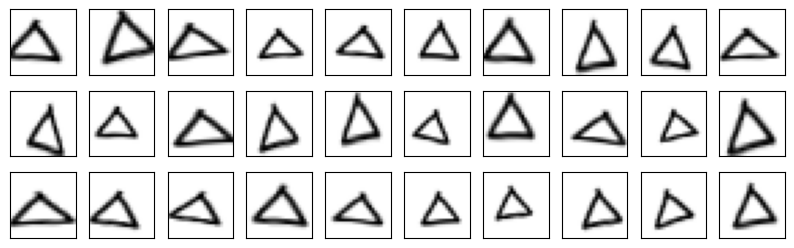

In [9]:
# train 데이터만 이런식으로 만들어서 훈련시킨다! (테스트는 테스트 데이터 그대로 사용, 이렇게 하지 않음!)
plt.figure(figsize=(10,3))
for i, fname in enumerate(glob('data/preview/*.png')):
    img = Image.open(fname)
    plt.subplot(3, 10, i+1)
    plt.imshow(img), plt.xticks([]), plt.yticks([])
plt.show()

- data generator

In [10]:
train_data_generator = train_datagen.flow_from_directory(       # 데이터를 가져올 경로 지정
    'data/hard_handwriting_shape/train', 
    target_size=(24,24),
    batch_size=3,
    class_mode='categorical'        # 3종류
)

Found 45 images belonging to 3 classes.


In [11]:
test_datagen = ImageDataGenerator(rescale=1/255.)
test_data_generator = test_datagen.flow_from_directory(     
    'data/hard_handwriting_shape/test', 
    target_size=(24,24),
    batch_size=3,
    class_mode='categorical' 
)

Found 15 images belonging to 3 classes.


- 모델 정의/설정/학습/평가

In [12]:
import numpy as np
import tensorflow as tf
seed = 2023
tf.random.set_seed(seed)
np.random.seed(seed)

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

In [14]:
model = Sequential([
    Conv2D(32, (3,3), input_shape=(24,24,3), activation='relu'),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(3, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 22, 22, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 20, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 10, 10, 64)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 6400)              0         
                                                                 
 dense (Dense)               (None, 128)               819328    
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                        

In [15]:
model.compile('adam', 'categorical_crossentropy', ['accuracy'])

In [16]:
model.fit(
    train_data_generator,  
    epochs=300, verbose=0,
    validation_data=test_data_generator,
    steps_per_epoch=15,         # 총 데이터 수(45) / batch_size(3) = 15 (train)
    validation_steps=5          # 총 데이터 수(15) / batch_size(3) = 5  (test)
)

In [17]:
model.evaluate(test_data_generator)

5/5 [==============================] - 0s 5ms/step - loss: 3.1194 - accuracy: 0.6667


[3.119351625442505, 0.6666666865348816]